# Predicting Listing Gains in the Indian IPO Market Using Deep Learning

## Table of Contents

- [1. Introducing and Loading Data](#1.-Introducing-and-Loading-Data)
- [2. Exploring and Visualizing the Data](#2.-Exploring-and-Visualizing-the-Data)
- [3. Treating the Outliers](#3.-Treating-the-Outliers)
- [4. Defining Variables and Splitting Data](#4.-Defining-Variables-and-Splitting-Data)
- [5. Building the Classification Models](#5.-Building-the-Classification-Models)
- [6. Evaluating the Classification Models](#6.-Evaluating-the-Classification-Models)
- [7. Exploring Model Configurations for Optimization](#7.-Exploring-Model-Configurations-for-Optimization)
- [8. Conclusion](#8.-Conclusion)

## 1. Introducing and Loading Data

In this project, we'll assume the role of a data scientist for an investment firm interested in the [Initial Public Offerings](https://www.investopedia.com/terms/i/ipo.asp) (IPOs) of the Indian market. Our goal is to develop several deep learning classification models to predict whether there will be listing gains for the IPOs. Listing gains refer to the percentage increase in a company's share price from its IPO issue price on the day of listing.

The dataset we'll use contains information on past IPOs in the Indian market and is sourced from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true). We will cover all the major steps of the modeling pipeline, beginning with exploratory data analysis, followed by visualizing the important variables, and finally creating deep learning classification models using sequential and functional APIs. Additionally, we'll optimize a neural network model to explore different settings and find the best model.

The data consists of the following columns:
- `Date` – The date the IPO was listed.
- `IPOName` – The name of the IPO.
- `Issue_Size` – The size of the IPO issue, in `INR Crores`.
- `Subscription_QIB` – The number of times subscribed by `QIB` (Qualified Institutional Buyer) investors.
- `Subscription_HNI` – The number of times subscribed by `HNI` (High Net Worth Individual) investors.
- `Subscription_RII` – The number of times subscribed by `RII` (Retail Individual Investors).
- `Subscription_Total` – The total number of times subscribed overall.
- `Issue_Price` – The issue price in `INR`.
- `Listing_Gains_Percent` – The percentage gain from the issue price to the listing price.

To begin, we’ll load the dataset, which is available as a CSV file, and import all the required libraries for our work.

In [1]:
# Import libraries for data handling, visualization, sampling, and modeling
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import kerastuner as kt

# Load and preview the first few rows of the IPO dataset
df = pd.read_csv('Datasets/Indian_IPO_Market_Data.csv')
df.head()

C:\Users\Gordias\AppData\Local\Temp\ipykernel_10872\2486940320.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


The dataset includes IPO listings with details such as the issue size, subscription levels from various investor categories (`QIB`, `HNI`, `RII`), the issue price, and listing gains. The data shows a wide range in issue sizes and subscription rates, with some IPOs experiencing significant listing gains, while others have notable losses. For example, `Infinite Comp` had a positive listing gain, whereas `Jubilant Food` faced a substantial decline.

In [2]:
# Generate summary statistics for all columns
df.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000


The dataset comprises `319` IPO records with no missing values. The average issue size is approximately `1192.86` INR Crores, and the wide standard deviation indicates substantial variability. Subscription rates vary significantly across IPOs, with a mean subscription total of `27.45` times. Additionally, the average listing gain is about `4.74%`, with some IPOs experiencing significant gains and others substantial losses; the maximum recorded listing gain is `270.40%`.

## 2. Exploring and Visualizing the Data

Since the `Listing_Gains_Percent` target variable is continuous, we need to convert it into a binary format. Also, we need to conduct some data exploration to determine the necessary data preprocessing steps for the dataset.

In [3]:
# Convert `Listing_Gains_Percent` to a binary format and check its distribution
df['Listing_Gains_Profit'] = np.where(df['Listing_Gains_Percent'] > 0, 1, 0)
df['Listing_Gains_Profit'].value_counts(normalize=True)

Listing_Gains_Profit
1    0.545455
0    0.454545
Name: proportion, dtype: float64

The result shows that approximately `54.55%` of IPOs experienced positive listing gains, while `45.45%` had negative or zero gains. This indicates a slightly higher proportion of IPOs with gains compared to those without.

Next, we’ll drop the following columns for these reasons:
- `Date` – It’s unlikely to provide predictive value and may introduce noise.
- `IPOName` – It’s a nominal feature with high cardinality and doesn’t contribute to model performance.
- `Listing_Gains_Percent` – It’s the original continuous target variable, which we've already converted to a binary format for classification.

In [4]:
# Drop the specified columns from the dataset
df = df.drop(['Date ', 'IPOName', 'Listing_Gains_Percent'], axis=1)

It’s time to create histograms of `Issue_Price` and `Issue_Size`, and examine their distribution with respect to the target variable `Listing_Gains_Profit` using boxplots. These insights could be informative for modeling.

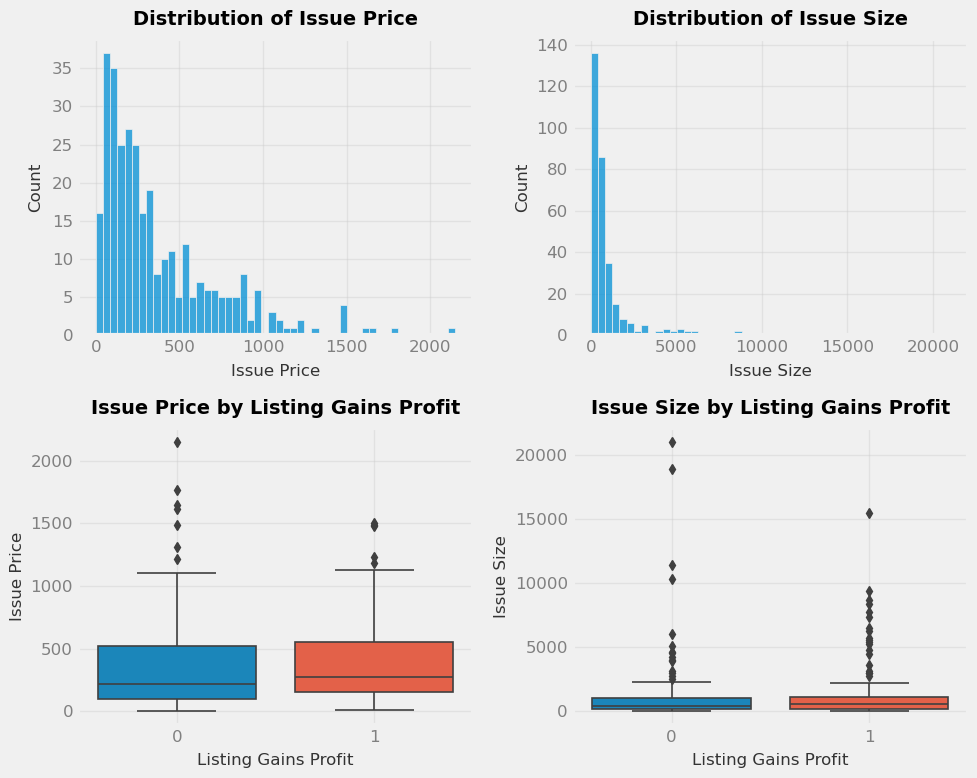

In [5]:
# Set style to "fivethirtyeight" and create subplots (2 rows, 2 columns)
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histogram of "Issue_Price"
sns.histplot(data=df, x='Issue_Price', bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Issue Price', weight='bold', fontsize=14, pad=10)
axes[0, 0].set_xlabel('Issue Price', color='#333333', fontsize=12, labelpad=6)
axes[0, 0].set_ylabel('Count', color='#333333', fontsize=12, labelpad=6)

# Plot histogram of "Issue_Size"
sns.histplot(data=df, x='Issue_Size', bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Issue Size', weight='bold', fontsize=14, pad=10)
axes[0, 1].set_xlabel('Issue Size', color='#333333', fontsize=12, labelpad=6)
axes[0, 1].set_ylabel('Count', color='#333333', fontsize=12, labelpad=4)

# Plot boxplot of "Issue_Price" by "Listing_Gains_Profit"
sns.boxplot(data=df, x='Listing_Gains_Profit', y='Issue_Price', linewidth=1.2, ax=axes[1, 0])
axes[1, 0].set_title('Issue Price by Listing Gains Profit', weight='bold', fontsize=14, pad=10)
axes[1, 0].set_xlabel('Listing Gains Profit', color='#333333' , fontsize=12, labelpad=6)
axes[1, 0].set_ylabel('Issue Price', color='#333333', fontsize=12, labelpad=4)

# Plot boxplot of "Issue_Size" by "Listing_Gains_Profit"
sns.boxplot(data=df, x='Listing_Gains_Profit', y='Issue_Size', linewidth=1.2, ax=axes[1, 1])
axes[1, 1].set_title('Issue Size by Listing Gains Profit', weight='bold', fontsize=14, pad=10)
axes[1, 1].set_xlabel('Listing Gains Profit', color='#333333', fontsize=12, labelpad=6)
axes[1, 1].set_ylabel('Issue Size', color='#333333', fontsize=12, labelpad=4)

# Adjust gridlines opacity and tick labels
for ax in axes.flat:
    ax.grid(True, alpha=0.4)
    ax.tick_params(axis='both', labelsize=12, colors='grey')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Based on the four subplots:

- The distribution of issue price is highly right-skewed, with `75%` of IPO issue prices concentrated below INR `536`, and a few outliers reaching at least INR `1500`.
- The distribution of issue size is also strongly right-skewed, with `75%` of IPOs having an issue size below INR `1100`. A few IPOs have much larger issue sizes, exceeding INR `5000` Crores.
- The boxplot of `Issue_Price` by `Listing_Gains_Profit` suggests there is no significant difference in issue prices between IPOs with listing gains (profitable IPOs) and those without, although IPOs without gains have more high outliers.
- Similarly, the boxplot of `Issue_Size` by `Listing_Gains_Profit` shows little distinction in issue sizes between IPOs with and without listing gains. Both categories exhibit a wide range of issue sizes, with large outliers, and their medians remain relatively close.

Finally, there is no clear relationship between both issue price and issue size and listing gains based on the boxplots. Other factors may play a more significant role in predicting listing gains.

Next, let's create scatter plots to show the correlation between `Subscription_QIB`, `Subscription_HNI`, and `Subscription_RII` with `Subscription_Total`, and how each variable impacts the total.

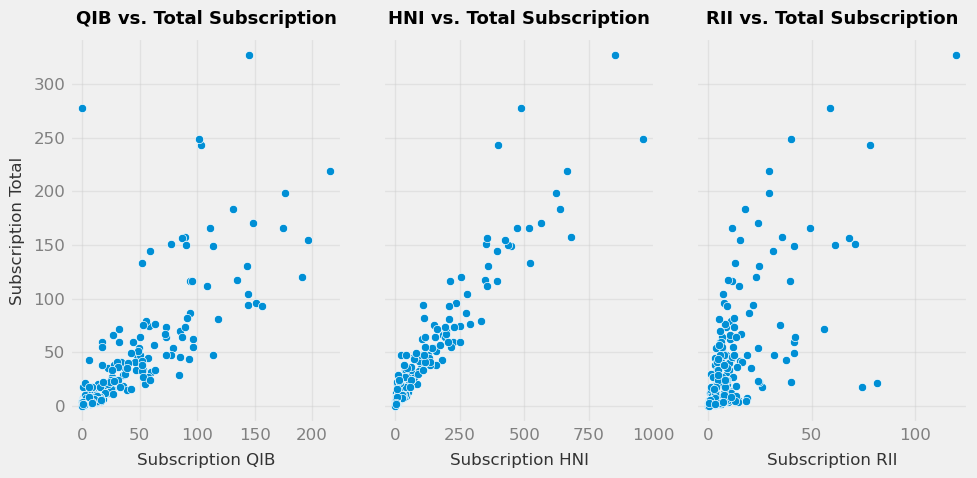

In [6]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# Make scatterplot for "Subscription_QIB" vs. "Subscription_Total"
sns.scatterplot(data=df, x='Subscription_QIB', y='Subscription_Total', ax=axes[0])
axes[0].set_title('QIB vs. Total Subscription', weight='bold', fontsize=13, pad=10)
axes[0].set_xlabel('Subscription QIB', color='#333333', fontsize=12, labelpad=7)
axes[0].set_ylabel('Subscription Total', color='#333333', fontsize=12, labelpad=6)

# Make scatterplot for "Subscription_HNI" vs. "Subscription_Total"
sns.scatterplot(data=df, x='Subscription_HNI', y='Subscription_Total', ax=axes[1])
axes[1].set_title('HNI vs. Total Subscription', weight='bold', fontsize=13, pad=10)
axes[1].set_xlabel('Subscription HNI', color='#333333', fontsize=12, labelpad=7)

# Make scatterplot for "Subscription_RII" vs. "Subscription_Total"
sns.scatterplot(data=df, x='Subscription_RII', y='Subscription_Total', ax=axes[2])
axes[2].set_title('RII vs. Total Subscription', weight='bold', fontsize=13, pad=10)
axes[2].set_xlabel('Subscription RII', color='#333333', fontsize=12, labelpad=7)

# Adjust gridlines opacity and tick labels
for ax in axes.flat:
    ax.grid(True, alpha=0.4)
    ax.tick_params(axis='both', labelsize=12, colors='grey')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The scatter plots show a positive correlation between Qualified Institutional Buyer (QIB), High Net Worth Individual (HNI), and Retail Individual Investor (RII) subscriptions and total subscriptions. `QIB` and `HNI` subscriptions have a stronger impact, significantly driving up overall totals. On the other hand, `RII` subscriptions, while still positively correlated, are more spread out and have a relatively smaller impact compared to QIBs and HNIs.

## 3. Treating the Outliers

To detect outliers, we’ll calculate the interquartile range (IQR) for all numerical columns. Once the lower and upper bounds are established, we’ll replace the outliers accordingly.

In [7]:
# List the columns to process for outlier removal
columns = ['Issue_Price', 'Issue_Size', 'Subscription_QIB',
           'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']

# Iterate over each column to handle outliers
for col in columns:
    
    # Calculate the first and third quartiles, plus the interquartile range (IQR)
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    iqr = q3 - q1
    
    # Define the lower and upper bounds, and clip outliers to the nearest bound
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df[col] = df[col].clip(lower, upper)

# Verify changes by checking summary statistics for each column
df.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,763.561238,21.521183,40.356426,6.060940,20.456646,362.147335,0.545455
std,769.689122,29.104549,57.427921,6.176882,27.217740,312.272967,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,0.000000
50%,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.000000
75%,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,1.000000
max,2496.492500,84.862500,153.355000,19.600000,81.020000,1161.500000,1.000000


After removing outliers, the mean values and standard deviations for `Issue_Price`, `Issue_Size`, `Subscription_QIB`, `Subscription_HNI`, `Subscription_RII`, and `Subscription_Total` have all decreased, reflecting a more focused distribution with reduced dispersion. This adjustment can enhance the stability and interpretability of the data for subsequent analysis.

## 4. Defining Variables and Splitting Data

Now that we've cleaned our data, we need to set the target and predictor variables, normalize the predictor values to a uniform scale, and balance the target classes by generating synthetic samples for the minority class.

Furthermore, we'll split the dataset into training and test sets, as well as into training, validation, and test sets. This is because we will use different data splits depending on the model we're building.

In [8]:
# Set predictors and target variable
target_variable = ['Listing_Gains_Profit'] 
predictors = list(set(list(df.columns)) - set(target_variable))

# Normalize predictor values to a uniform scale
df[predictors] = df[predictors] / df[predictors].max()

# Extract predictor and target variables
X = df[predictors].values
y = df[target_variable].values

# Perform random oversampling to balance the classes
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

# Compute and print the number of 0s and 1s in the target variable
counts = np.bincount(y_resampled)
print(f'Target variable distribution - 0s: {counts[0]}, 1s: {counts[1]}')

Target variable distribution - 0s: 174, 1s: 174


The target variable distribution has become balanced, with `174` instances for both `0s` and `1s`. Previously, the target variable showed `54.55%` for `1s` and `45.45%` for `0s`, and the dataset contained `319` entries before we generated synthetic samples, increasing the total to `348`.

In [9]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3, random_state=42)

# Split the resampled data: 80% for training, 20% temporary
X_train_new, X_temp, y_train_new, y_temp = train_test_split(X_resampled, y_resampled,
                                                            test_size=0.2, random_state=42)

# Split the temporary data: 10% validation, 10% test
X_val, X_test_new, y_val, y_test_new = train_test_split(X_temp, y_temp,
                                                        test_size=0.5, random_state=42)

## 5. Building the Classification Models

When defining a deep learning model, we need to instantiate the model, add hidden layers, and choose appropriate activation functions. Compiling the model requires specifying an optimizer, a loss function, and an evaluation metric. Only then can we fit the model to the training dataset.

To get started, let's build two models using the sequential and functional APIs.

In [10]:
# Initialize a Sequential model
sequential_model = tf.keras.Sequential()

# Add input layer, hidden layers with ReLU activation, and output layer for binary classification
sequential_model.add(tf.keras.Input(shape=(X_train_new.shape[1],)))
sequential_model.add(tf.keras.layers.Dense(32, activation='relu'))
sequential_model.add(tf.keras.layers.Dense(16, activation='relu'))
sequential_model.add(tf.keras.layers.Dense(8, activation='relu'))
sequential_model.add(tf.keras.layers.Dense(4, activation='relu'))
sequential_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
sequential_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Display model architecture
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define input layer with the specified shape
inputs = tf.keras.Input(shape=(X_train.shape[1],))

# Add hidden layers with ReLU activation and Dropout regularization
x = tf.keras.layers.Dense(32, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation='relu')(x)

# Define output layer with 1 unit and sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create and compile the functional model with Adam, binary cross-entropy, and accuracy
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)
functional_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Display model architecture
functional_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

While both models are designed for binary classification, the sequential model has a total of `929` parameters, with five dense layers where each layer's output shape progressively decreases. The functional model, also having `929` parameters, includes an input layer, five dense layers, and three dropout layers that help reduce overfitting.

## 6. Evaluating the Classification Models

Now that we have compiled our deep learning models, the next step is to train them and evaluate their performance. Here are some guiding questions to keep in mind:
- What's the accuracy on the training, validation, and test datasets? It's worth noting that we'll use a validation set only for the model with the sequential API.
- Is the accuracy consistent across both the training and test datasets for each model?

This evaluation allows us to identify areas where each model can be improved or fine-tuned to achieve better results.

In [12]:
# Train the sequential model with early stopping and validation data
sequential_model.fit(X_train_new, y_train_new,
                     validation_data=(X_val, y_val),
                     callbacks=tf.keras.callbacks.EarlyStopping(patience=2),
                     epochs=250)

Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5265 - loss: 0.6906 - val_accuracy: 0.4857 - val_loss: 0.6872
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5299 - loss: 0.6834 - val_accuracy: 0.4857 - val_loss: 0.6832
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5005 - loss: 0.6793 - val_accuracy: 0.4857 - val_loss: 0.6794
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4990 - loss: 0.6774 - val_accuracy: 0.4857 - val_loss: 0.6757
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 0.6745 - val_accuracy: 0.4857 - val_loss: 0.6720
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5114 - loss: 0.6685 - val_accuracy: 0.5429 - val_loss: 0.6678
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5602 - loss: 0.6684 - val_accuracy: 0.6000 - val_loss: 0.6631
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5755 - loss: 0.6556 - val_accuracy: 0.6000 - val_loss: 0.6582

In [13]:
# Train the functional model for 250 epochs
functional_model.fit(X_train, y_train, epochs=250)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4554 - loss: 0.6925  
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.4989 - loss: 0.6873
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5288 - loss: 0.6752 
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5367 - loss: 0.6685 
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.5236 - loss: 0.6844
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.5235 - loss: 0.6710
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5329 - loss: 0.6640
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.4937 - loss: 0.6758
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5760 - loss: 0.6761
Epoch 10/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.5923 - loss: 0.6707
Epoch 11/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6083 - loss: 0.6550 
Epoch 12/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6591 - loss: 0.6346 
Epoch 138/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6852 - loss: 0.6143 
Epoch 139/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7149 - loss: 0.6027
Epoch 140/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.6608 - loss: 0.6134
Epoch 141/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6773 - loss: 0.6107
Epoch 142/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.6269 - loss: 0.6289
Epoch 143/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6185 - loss: 0.6527 
Epoch 144/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.6102 - loss: 0.6450
Epoch 145/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6126 - loss: 0.6350
Epoch 146/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.6378 - loss: 0.6289
Epoch 147/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.6422 - loss: 0.6329
Epoch 148/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accur

Now, we're ready to evaluate both the sequential and functional models on training and test datasets.

In [14]:
# Evaluate the sequential model on training and test datasets
print(sequential_model.evaluate(X_train_new, y_train_new))
print(sequential_model.evaluate(X_test_new, y_test_new))

# Evaluate the functional model on training and test datasets
print(functional_model.evaluate(X_train, y_train))
print(functional_model.evaluate(X_test, y_test))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.6920 - loss: 0.6035
[0.6042953729629517, 0.6798561215400696]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7054 - loss: 0.6731 
[0.6654502749443054, 0.7142857313156128]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7146 - loss: 0.5814
[0.5938079953193665, 0.6913580298423767]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7132 - loss: 0.6231 
[0.624554455280304, 0.7047619223594666]


The evaluation results show the following:

1. The sequential model achieves an accuracy of `69.2%` on the training dataset and `70.54%` on the test dataset, with a loss of `0.6035` on training and `0.6731` on testing. This indicates that the model performs reasonably well, with a marginally higher accuracy on the test dataset, suggesting effective generalization to unseen data.
2. The functional model displays an accuracy of about `71.46%` on the training dataset and `71.32%` on the test dataset, with a loss of `0.5814` on training and `0.6231` on testing. This suggests that the model is performing comparably on both datasets without significant overfitting.

Although both models perform similarly, the functional model performs slightly better overall. Further tuning or additional data could enhance performance.

## 7. Exploring Model Configurations for Optimization

We'll explore different configurations of a neural network classification model to optimize its performance. We'll experiment with various hyperparameters such as the number of units in each layer, activation functions, and dropout rates. After running the optimization process, we'll review the optimal model and summarize the key hyperparameters that contribute to its performance.

In [15]:
def build_model(hp):
    
    # Initialize a sequential model and add input layer
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(X_train_new.shape[1],)))

    # Add first hidden layer with specified units and activation functions, and add Dropout layer
    model.add(tf.keras.layers.Dense(
        hp.Int('units_1', min_value=8, max_value=128, step=8), 
        activation=hp.Choice('activation_1', ['relu', 'tanh'])
    ))
    model.add(tf.keras.layers.Dropout(
        hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    # Add second hidden layer with specified units and activation functions, and add Dropout layer
    model.add(tf.keras.layers.Dense(
        hp.Int('units_2', min_value=8, max_value=128, step=8), 
        activation=hp.Choice('activation_2', ['relu', 'tanh'])
    ))
    model.add(tf.keras.layers.Dropout(
        hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    ))

    # Add third hidden layer with specified units and activation functions, and add output layer
    model.add(tf.keras.layers.Dense(
        hp.Int('units_3', min_value=4, max_value=64, step=4), 
        activation=hp.Choice('activation_3', ['relu', 'tanh'])
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Define learning rate as a hyperparameter, then compile and return the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Initialize the random search tuner for hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    max_trials=15,
    executions_per_trial=5,
    objective='val_accuracy',
    directory='Tuning Directory', 
    project_name='model_optimization')

# Start the hyperparameter search on the training data
tuner.search(X_train_new, y_train_new, 
             epochs=150,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

# Retrieve the best model and hyperparameters, then display the model summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]

# Print the optimal hyperparameters found during tuning
print(f"""
The optimal activation function for the first layer is {best_hps.get('activation_1')}.
The optimal dropout rate for the first layer is {best_hps.get('dropout_1')}.

The optimal activation function for the second layer is {best_hps.get('activation_2')}.
The optimal dropout rate for the second layer is {best_hps.get('dropout_2')}.

The optimal activation function for the third layer is {best_hps.get('activation_3')}.
The optimal learning rate is {best_hps.get('learning_rate'):.4f}.
""")

Trial 15 Complete [00h 00m 12s]
val_accuracy: 0.7600000143051148

Best val_accuracy So Far: 0.7828571557998657
Total elapsed time: 00h 03m 56s


C:\Users\Gordias\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,849 (7.22 KB)

 Trainable params: 1,849 (7.22 KB)

 Non-trainable params: 0 (0.00 B)


The optimal activation function for the first layer is relu.
The optimal dropout rate for the first layer is 0.1.

The optimal activation function for the second layer is relu.
The optimal dropout rate for the second layer is 0.1.

The optimal activation function for the third layer is relu.
The optimal learning rate is 0.0035.



Next, we'll fit the best model on the training data and then evaluate it on training and test datasets.

In [16]:
# Train the best model with early stopping and validation data
best_model.fit(X_train_new, y_train_new,
               validation_data=(X_val, y_val),
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
               epochs=150)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6247 - loss: 0.6649 - val_accuracy: 0.8000 - val_loss: 0.6353
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6291 - loss: 0.6623 - val_accuracy: 0.8000 - val_loss: 0.6189
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.6506 - val_accuracy: 0.7143 - val_loss: 0.6117
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6345 - loss: 0.6219 - val_accuracy: 0.7143 - val_loss: 0.6019
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6687 - loss: 0.6260 - val_accuracy: 0.7143 - val_loss: 0.5968
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6255 - loss: 0.6484 - val_accuracy: 0.7429 - val_loss: 0.5930
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.6323 - val_accuracy: 0.7429 - val_loss: 0.5902
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6592 - loss: 0.6295 - val_accuracy: 0.7143 - val_loss: 0.5906

In [17]:
# Evaluate the best model on training and test datasets
print(best_model.evaluate(X_train_new, y_train_new))
print(best_model.evaluate(X_test_new, y_test_new))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.6940 - loss: 0.6108
[0.6168997287750244, 0.6762589812278748]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7054 - loss: 0.6219 
[0.6153743267059326, 0.7142857313156128]


The best model shows an accuracy of approximately `69.4%` on the training dataset, with a loss of around `0.6108`. On the test dataset, the model achieves a slightly higher accuracy of about `70.54%` and a loss of `0.6219`. Overall, the model demonstrates reasonable performance and generalizes well to unseen data, but there may still be room for improvement.

## 8. Conclusion

In this project, we acted as data scientists for an investment firm interested in Indian [Initial Public Offerings](https://www.investopedia.com/terms/i/ipo.asp) (IPOs). The dataset, sourced from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true), includes details on past IPOs, such as issue size, subscription levels (`QIB`, `HNI`, `RII`), issue price, and listing gains. It highlights varying issue sizes, subscription rates, and listing gains or losses. Additionally, we generated summary statistics for all columns.

We converted the continuous target variable, `Listing_Gains_Percent`, into a binary format by creating a new column, `Listing_Gains_Profit`, and removed irrelevant columns, including the original target variable. Histograms of `Issue_Price` and `Issue_Size` revealed highly right-skewed distributions. Boxplots showed no clear relationship between these variables and listing gains, suggesting other factors may be more significant in predicting listing gains.

Furthermore, scatter plots revealed a positive correlation between subscriptions from Qualified Institutional Buyers (QIB), High Net Worth Individuals (HNI), and Retail Individual Investors (RII) with total subscriptions. `QIB` and `HNI` subscriptions had a stronger impact, significantly increasing overall totals, while `RII` subscriptions, though positively correlated, were more dispersed and had a relatively smaller influence. To detect outliers, we calculated the interquartile range (IQR) for all numerical columns. After establishing the lower and upper bounds, we replaced the outliers accordingly. Removing these outliers resulted in decreased mean values and standard deviations for our numerical columns, reflecting a more concentrated distribution with reduced dispersion.

After cleaning the dataset, we set the target and predictor variables, normalized the predictor values to a uniform scale, and balanced the target classes by generating synthetic samples for the minority class. Since we intended to use different data splits depending on the model being built, we divided the dataset into training and test sets, as well as training, validation, and test sets. Moreover, the target variable distribution is now balanced, with `174` instances for both classes (`0s` and `1s`). Initially, the target variable showed `54.55%` for `1s` and `45.45%` for `0s`. The dataset contained `319` entries before generating synthetic samples, increasing the total to `348`.

We built two deep learning models for binary classification using the sequential and functional APIs. The sequential model has `929` parameters across five dense layers, with each layer's output shape progressively decreasing. The functional model also has `929` parameters and includes an input layer, five dense layers, and three dropout layers to help reduce overfitting. Additionally, we explored various configurations of a neural network classification model to optimize performance. We experimented with hyperparameters such as the number of units in each layer, activation functions, and dropout rates. After the optimization process, we reviewed the optimal model and summarized the key hyperparameters contributing to its performance.

After fitting all models to their respective training data (and validation data only for the sequential and optimized models with early stopping) and evaluating them on the training and test datasets, the results show the following:

| Model            | Training Accuracy | Test Accuracy | Training Loss | Test Loss |
|------------------|-------------------|---------------|---------------|-----------|
| Sequential Model | 69.2%             | 70.54%        | 0.6035        | 0.6731    |
| Functional Model | 71.46%            | 71.32%        | 0.5814        | 0.6231    |
| Optimized Model  | 69.4%             | 70.54%        | 0.6108        | 0.6219    |

The sequential and optimized models perform reasonably well, with marginally higher accuracies on the test dataset, suggesting effective generalization to unseen data. The functional model performs comparably on both datasets without significant overfitting. Notably, the use of a validation set with early stopping for the sequential and optimized models likely contributed to reducing overfitting. Although all models show similar performance, the functional model has a slight edge overall. Further tuning or additional data could enhance performance for all three models.